## Waterpixels

This is an image processing project made by two Télécom Paris students in November 2023:
Yanis Aït El Cadi and Zakaria Chahboune.
The goal is to create 'Super Pixels' using the Watershed algorithm, hence the name 'Waterpixels'.

We applied the method of a research article:
VaïaMachairas,MatthieuFaessel,DavidCárdenas-Peña,ThéodoreChabardes,ThomasWalter,et
al.. Waterpixels.IEEETransactionsonImageProcessing,InstituteofElectricalandElectronics
Engineers, 2015,24(11),pp.3707-3716. 10.1109/TIP.2015.2451011 . hal-01212760 

Here are the main steps of the algorithm:
- Pre-processing of the image (opening-closing)
- Taking the gradient
- Creating regularly spaced cells
- Marker selection for each cell
- Gradient regularization
- Watershed algorithm

We will finally provide tools to evaluate the quality of the superpixels.

### Imports

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from scipy.ndimage import label
import skimage.segmentation as seg
import skimage.morphology as morpho
import math

### Useful functions

In [2]:
def morpho_gradient(img):
    morpho_grad = morpho.dilation(img)- morpho.erosion(img)
    return morpho_grad

def open_close(gray,sigma):
    gray = np.asarray(gray, dtype=np.uint8) # Specifying dtype is critical here
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(math.ceil(sigma*sigma/16),math.ceil(sigma*sigma/16)))
    opening = cv.morphologyEx(gray, cv.MORPH_OPEN, kernel)
    closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel)
    return closing

def mask(img, width = 25, space = 30):
    # marges sur les bords de l'image, d'épaisseur th=space-width
    th = space-width
    l,c = img.shape
    mask = np.ones((l,c), np.uint8)*255
    for i in range(th, l):
        for j in range(th, c):
            mask[i,j] = 0 if (i%space<width) and (j%space<width) and (i<l-th) and (j<c-th) else 255
    return mask

def find_clusters(img, i, j, space):
    # img has to be a gradient image
    extract_img = img[i:i+space, j:j+space]
    min = np.min(extract_img)
    new_image = np.zeros(extract_img.shape)
    new_image = np.where(extract_img==min, 1, 0)
    labeled, num_features = label(new_image)
    cluster_lengths = [0] 
    for k in range (1,num_features+1):
        cluster_k = np.where(labeled==k, 1, 0)
        cluster_lengths += [ np.sum(cluster_k) ]
    # cluster_lengths[k] contains the length of the cluster k
    k_max = np.argmax(cluster_lengths)
    biggest_cluster = np.where(labeled==k_max, 1, 0)
    coord = np.argwhere(biggest_cluster==1)
    # coordinates of the entire image
    coord[:,0] += i 
    coord[:,1] += j
    return biggest_cluster, coord # return cluster coordinates

def clusters(img, space):
    # img has to be a gradient image
    coord_list = []
    grid = np.zeros(img.shape)
    nb_cluster=1
    for i in range(0, img.shape[0], space):
        for j in range(0, img.shape[1], space):
            clust, coord = find_clusters(img, i, j, space)
            coord_list += [coord]
            # for the watershed, each cluster needs to have a different value
            grid[i:i+space, j:j+space]=clust*nb_cluster 
            nb_cluster += 1
    return grid, coord_list

### Evaluation functions

In [3]:
def contour_density(sp_im):
    cd = 0
    cd += len(sp_im)*2
    cd += len(sp_im[0])*2 
    for i in range(len(sp_im)):
        for j in range(len(sp_im[0])):
            if sp_im[i][j][0] == 0:
                cd += 1/2
    cd = cd / (len(sp_im)*len(sp_im[0]))
    return cd

def boundary_recall(sp_im,gt_im):
    ima = cv.imread(gt_im)
    ima = cv.cvtColor(ima, cv.COLOR_BGR2GRAY)
    sp_im = cv.cvtColor(sp_im, cv.COLOR_BGR2GRAY)
    gt_card = 0
    for elt in ima:
        for elt_ in elt:
            if elt_ == 0:
                gt_card += 1
    br = 0
    for i in range(len(ima)):
        for j in range(len(ima[0])):
            if ima[i,j] ==0:
                if is_sp_close(3,[i,j],sp_im):
                    br +=1
    br = br / gt_card
    return br

def manhattan_d(x,y):
    x1 = abs(x[0]-y[0])
    x2 =abs(x[1]-y[1])
    y = x1 + x2
    return y

def is_sp_close(distance,coo,sp_im):
    for i in range(max(0,coo[0]-distance),min(len(sp_im),coo[0]+distance)):
        for j in range(max(0,coo[1]-distance),min(len(sp_im[0]),coo[1]+distance)):
            if sp_im[i][j] == 0 and manhattan_d([i,j],coo) < distance:
                return True
    return False
def max(a,b):
    if a>b:
        return a
    else :
        return b

def min(a,b):
    if a>b:
        return b
    else :
        return a

def abs(a):
    if a < 0:
        return -a
    else :
        return a


### Main function

In [9]:
def main(name, k=5, sigma=20, thickness = 2, color=[0,0,0], show_steps = False):
    """ 
    inputs : name: image name like "papillon.jpg"
             k : gradient regularization parameter
             sigma: step of the algorithm
             thickness: size of the margin to avoid getting too close clusters
             color : color of the waterpixel borders
    output : array image with waterpixels
    """
    # parameters
    space = sigma
    width = space-thickness

    # image
    img = plt.imread(name)
    img_morph = open_close(img,space/2)
    img_gray = cv.cvtColor(img_morph, cv.COLOR_BGR2GRAY) # gray

    # gradient
    grad = morpho_gradient(img_gray) # gradient
    masked_grad = cv.add(grad, mask(grad, width, space)) # margin and square mask

    # clusters = markers
    grid, coord = clusters(masked_grad, space) # find clusters of min gradient in square areas
    markers0 = np.array(grid.copy())
    markers0 = markers0.astype(np.int32)

    # distance transform
    tresh = np.where(grid!=0, 0, 1) # clusters get 0, other pixels get 1
    tresh = cv.convertScaleAbs(tresh) 
    distTransform= cv.distanceTransform(tresh, cv.DIST_L2, 3) # gives map of distances to closest cluster

    # regularised gradient
    reg_grad = grad + 2* k* distTransform/sigma # formula from the article
    reg_grad = cv.cvtColor(reg_grad, cv.COLOR_GRAY2RGB) # gray image in RGB format
    reg_grad = cv.convertScaleAbs(reg_grad)

    # watershed
    markers = cv.watershed(reg_grad, markers0)
    output = np.array(img.copy())
    output[markers == -1] = color # set waterpixel borders to color (black by default)

    # show steps
    if show_steps:
        plt.figure(figsize=(20, 10))
        
        plt.subplot(3, 3, 1)
        plt.imshow(img)
        plt.title('Original image')
        
        plt.subplot(3, 3, 2)
        plt.imshow(img_morph, cmap='gray')
        plt.title('Opening-closing')
        
        plt.subplot(3, 3, 3)
        plt.imshow(img_gray, cmap='gray')
        plt.title('Gray')
        
        plt.subplot(3, 3, 4)
        plt.imshow(grad, cmap='gray')
        plt.title('Gradient')
        
        plt.subplot(3, 3, 5)
        plt.imshow(masked_grad, cmap='gray')
        plt.title('Masked gradient')
        
        plt.subplot(3, 3, 6)
        plt.imshow(markers0, cmap='gray')
        plt.title('Markers')
        
        plt.subplot(3, 3, 7)
        plt.imshow(distTransform, cmap='tab20')
        plt.title('Distance transform')
        
        plt.subplot(3, 3, 8)
        plt.imshow(reg_grad, cmap='gray')
        plt.title('Regularized gradient')
        
        plt.subplot(3, 3, 9)
        plt.imshow(output)
        plt.title('Waterpixels')
        
        plt.show()



    return output

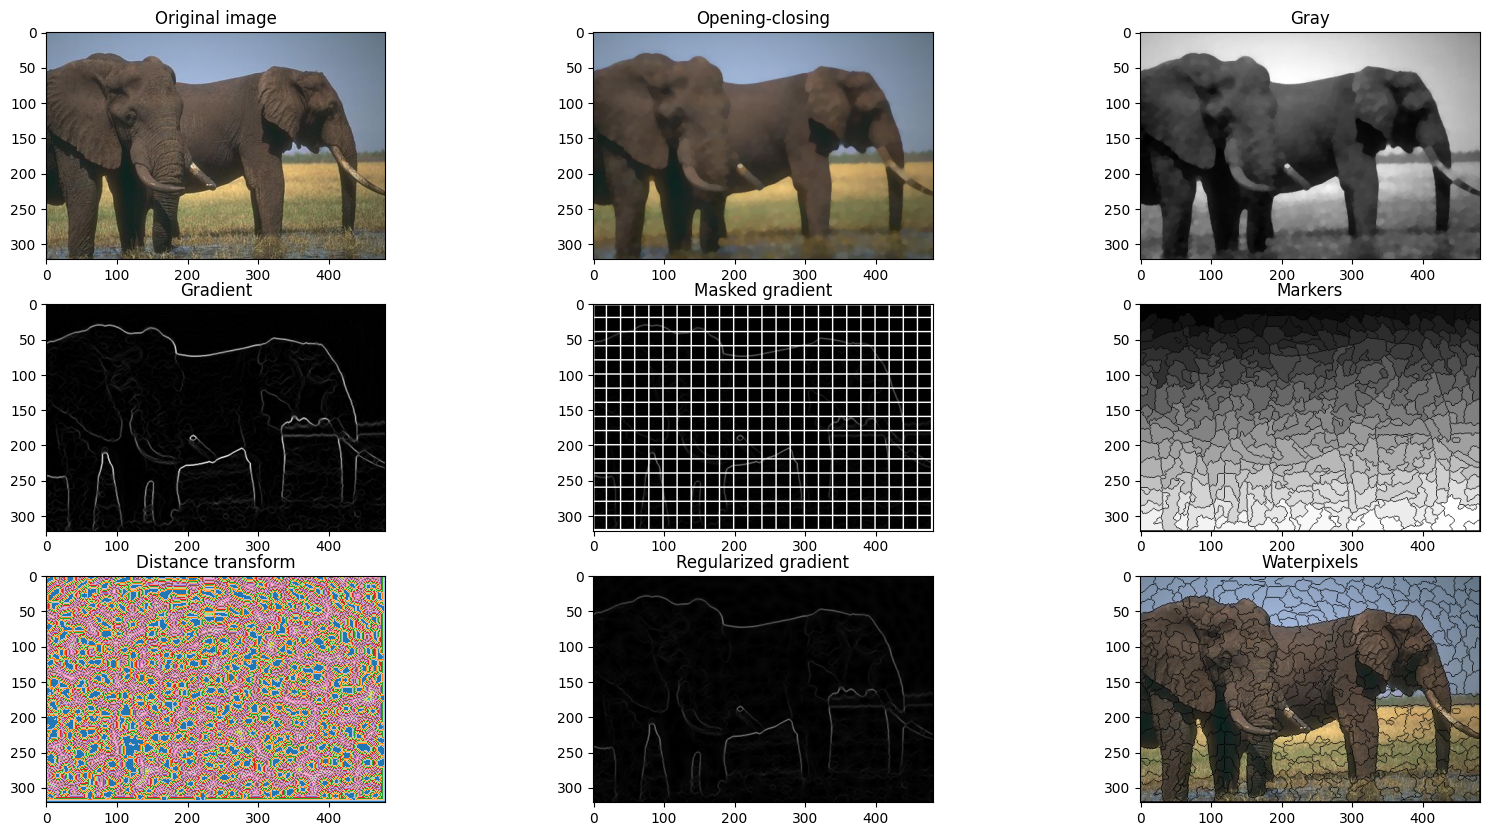

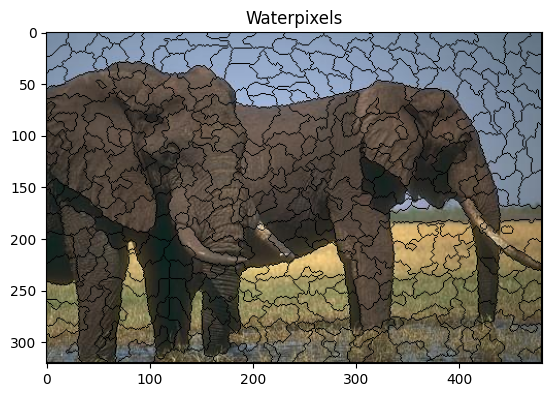

Contour Density :  0.06402484439867617
Boundary Recall :  0.8304093567251462


In [10]:
img_name = 'elephant.jpg'
output = main(img_name, show_steps=True)
plt.imshow(output)
plt.title('Waterpixels')
plt.show()

# Evaluation
cd = contour_density(output)
print("Contour Density : ", cd)
gt_name = 'GT_elephant.jpg'
br = boundary_recall(output,gt_name)
print("Boundary Recall : ", br)


### Parameter Evaluation

In [ ]:
def BR_eval(img_name, kmin=0, kmax=10, step=1):
    """
    Plots the Boundary recall in function of k.
    Must have image and Ground Truth image in the same folder
    The Ground Trut image can be found in the Berkeley image database
    It has to be named "GT_" + image_name:
    -img_name = "papillon.jpg" for example
    -gt_image_name = "GT_papillon.jpg"
    """
    k_ = []
    br_ = []
    for i in range(kmin, kmax, step):
        a = main(img_name, k=i)
        b = boundary_recall(a,"GT_"+img_name) 
        k_.append(i)
        br_.append(b)
    plt.plot(k_,br_)
    plt.show()

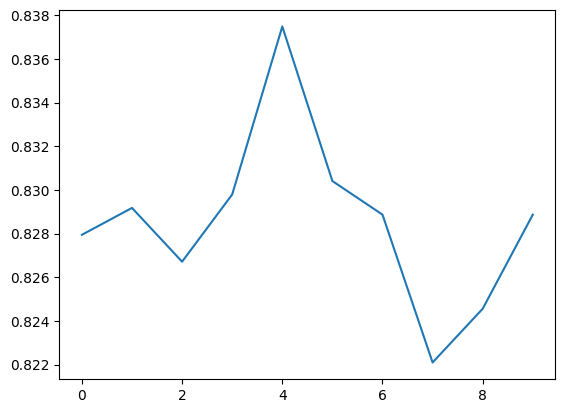

In [ ]:
BR_eval(img_name, kmin=0, kmax=10, step=1)